## ARIMA-model

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.stattools import adfuller

In [2]:
var_set = pd.read_csv('var_set.csv',index_col=0)

In [3]:
var_set.info()

<class 'pandas.core.frame.DataFrame'>
Index: 507 entries, 2013-04-07 to 2022-12-18
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   SalmonPrice   507 non-null    float64
 1   CodPrice      507 non-null    float64
 2   HalibutPrice  507 non-null    float64
 3   CPI           507 non-null    float64
dtypes: float64(4)
memory usage: 19.8+ KB


In [4]:
dftest1 = adfuller(var_set.SalmonPrice, autolag="AIC") 
dftest2 = adfuller(var_set.CodPrice, autolag="AIC") 
dftest3 = adfuller(var_set.HalibutPrice, autolag="AIC") 
dftest4 = adfuller(var_set.CPI, autolag="AIC") 

print(dftest1)
print(dftest2)
print(dftest3)
print(dftest4)

if dftest1[1] < 0.05:
  print("Salmon price is stationary.")
else:
  print("Salmon price is not stationary.")

(-2.812510810763277, 0.056508790887433394, 3, 503, {'1%': -3.4434175660489905, '5%': -2.8673031724657454, '10%': -2.5698395516760275}, 2680.129894878004)
(-0.6352337678513443, 0.8628202644567475, 2, 504, {'1%': -3.443391504492468, '5%': -2.8672917032172953, '10%': -2.5698334393109095}, 1779.454884533463)
(-1.4480497608947676, 0.5590362239760379, 17, 489, {'1%': -3.4437936797256317, '5%': -2.867468682890213, '10%': -2.5699277594606915}, 2266.7400116750127)
(2.2304173352508943, 0.9989066139956019, 19, 487, {'1%': -3.443849184997939, '5%': -2.8674931065091105, '10%': -2.569940776113236}, -1049.138745450044)
Salmon price is not stationary.


In [5]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

/Users/vrognaas/opt/anaconda3/envs/bachelor2023/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


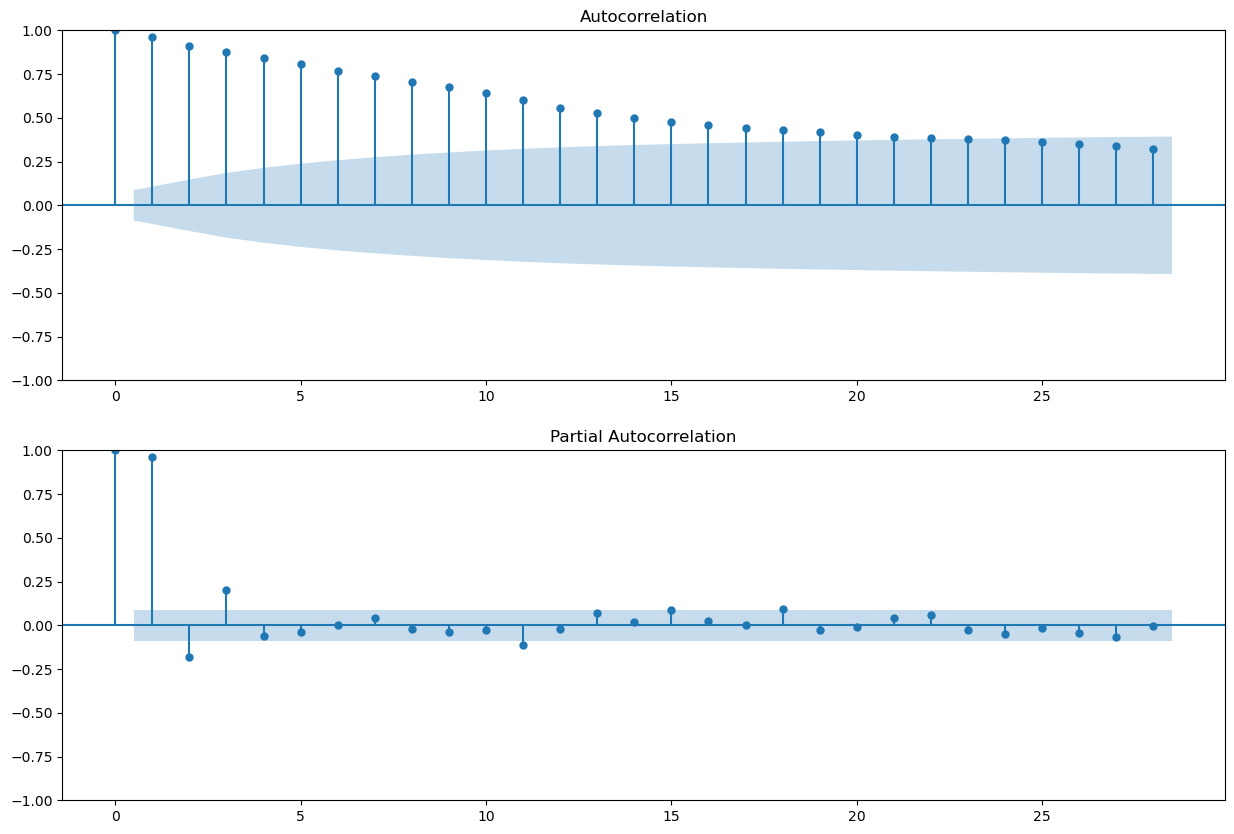

In [6]:
fig, ax = plt.subplots(2,1, figsize=(15,10))
plot_acf(var_set.SalmonPrice, ax=ax[0])
plot_pacf(var_set.SalmonPrice, ax=ax[1])

plt.show()